<a href="https://colab.research.google.com/github/Pankaj-2003/Computer_Vision_Project/blob/main/Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
# !pip install torchmetrics
import zipfile

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from torchvision.utils import save_image
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from u2net import U2NET  # You'll need to import the U-2-Net architecture

In [3]:
zip_paths = ['/content/Image-20240807T073037Z-001.zip' , '/content/Mask-20240807T073036Z-001.zip'] #list of names of zip files

for zip_path in zip_paths: # iterating over those files
  with zipfile.ZipFile(zip_path, 'r') as zip_ref: # extracting folder inside them
      zip_ref.extractall()

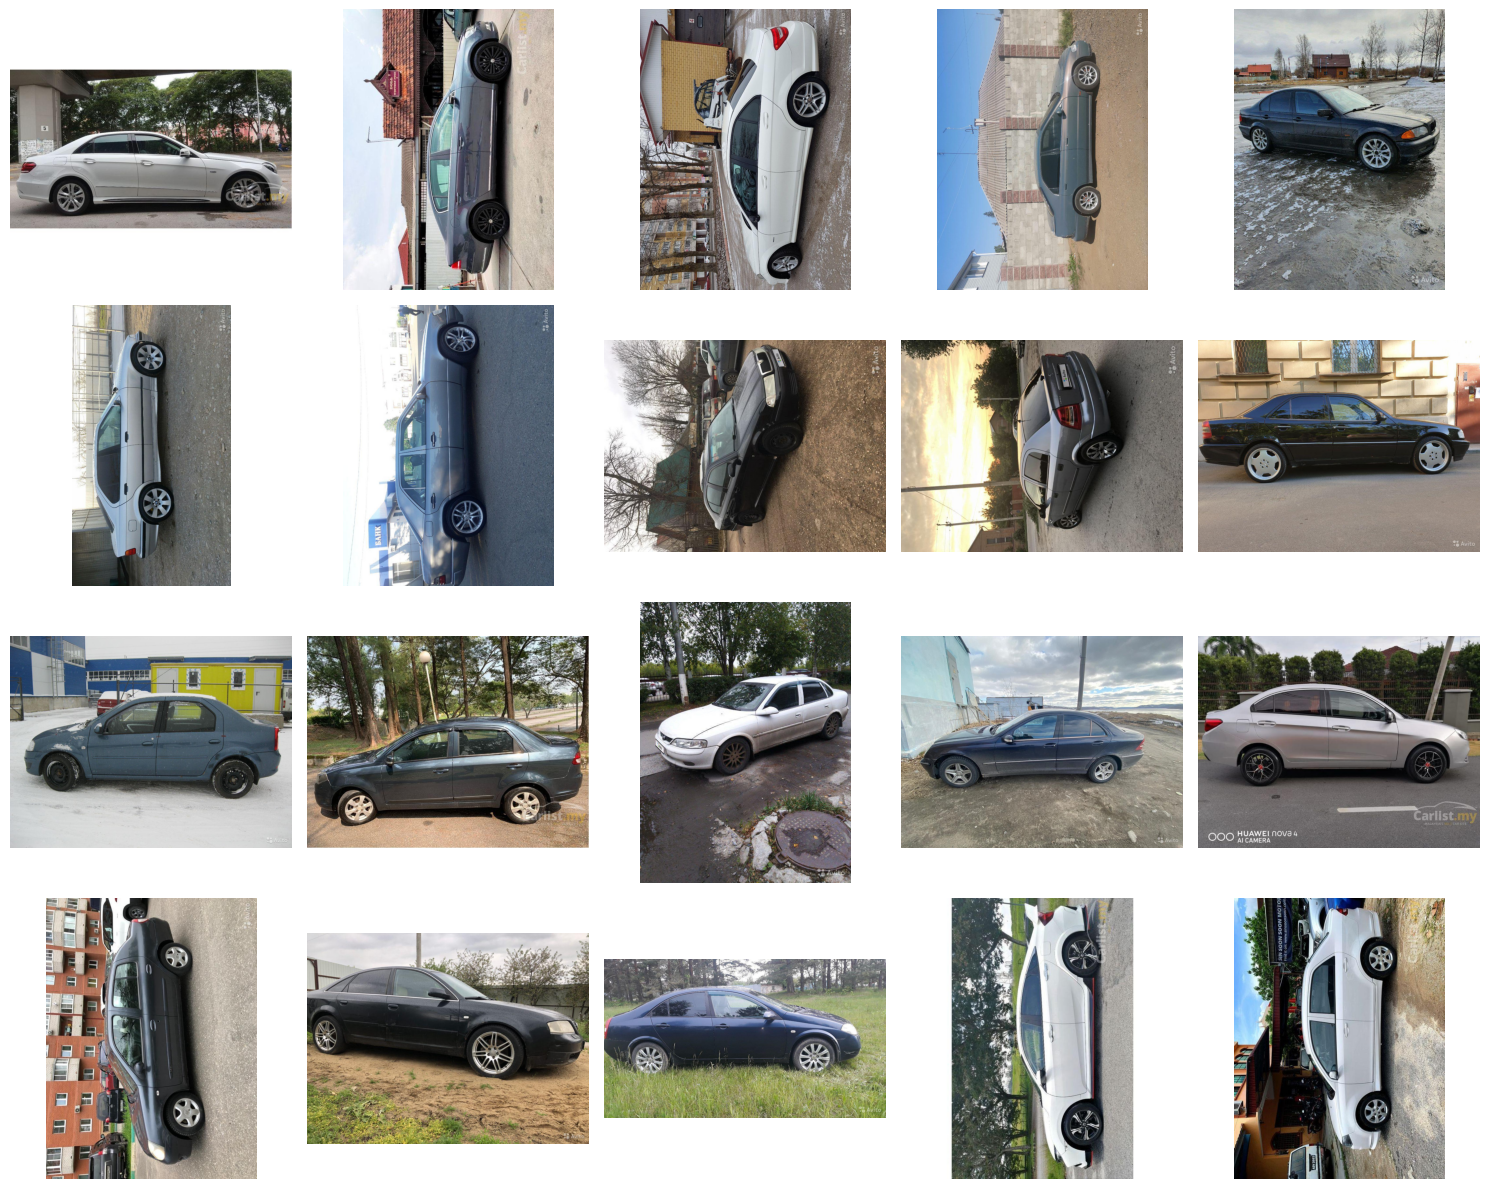

In [6]:
folder_image = "/content/Image" # folder path of images
images = [Image.open(os.path.join(folder_image , f)) for f in os.listdir(folder_image)] # displaying every image present in images folder
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for ax, img in zip(axes.ravel(), images):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


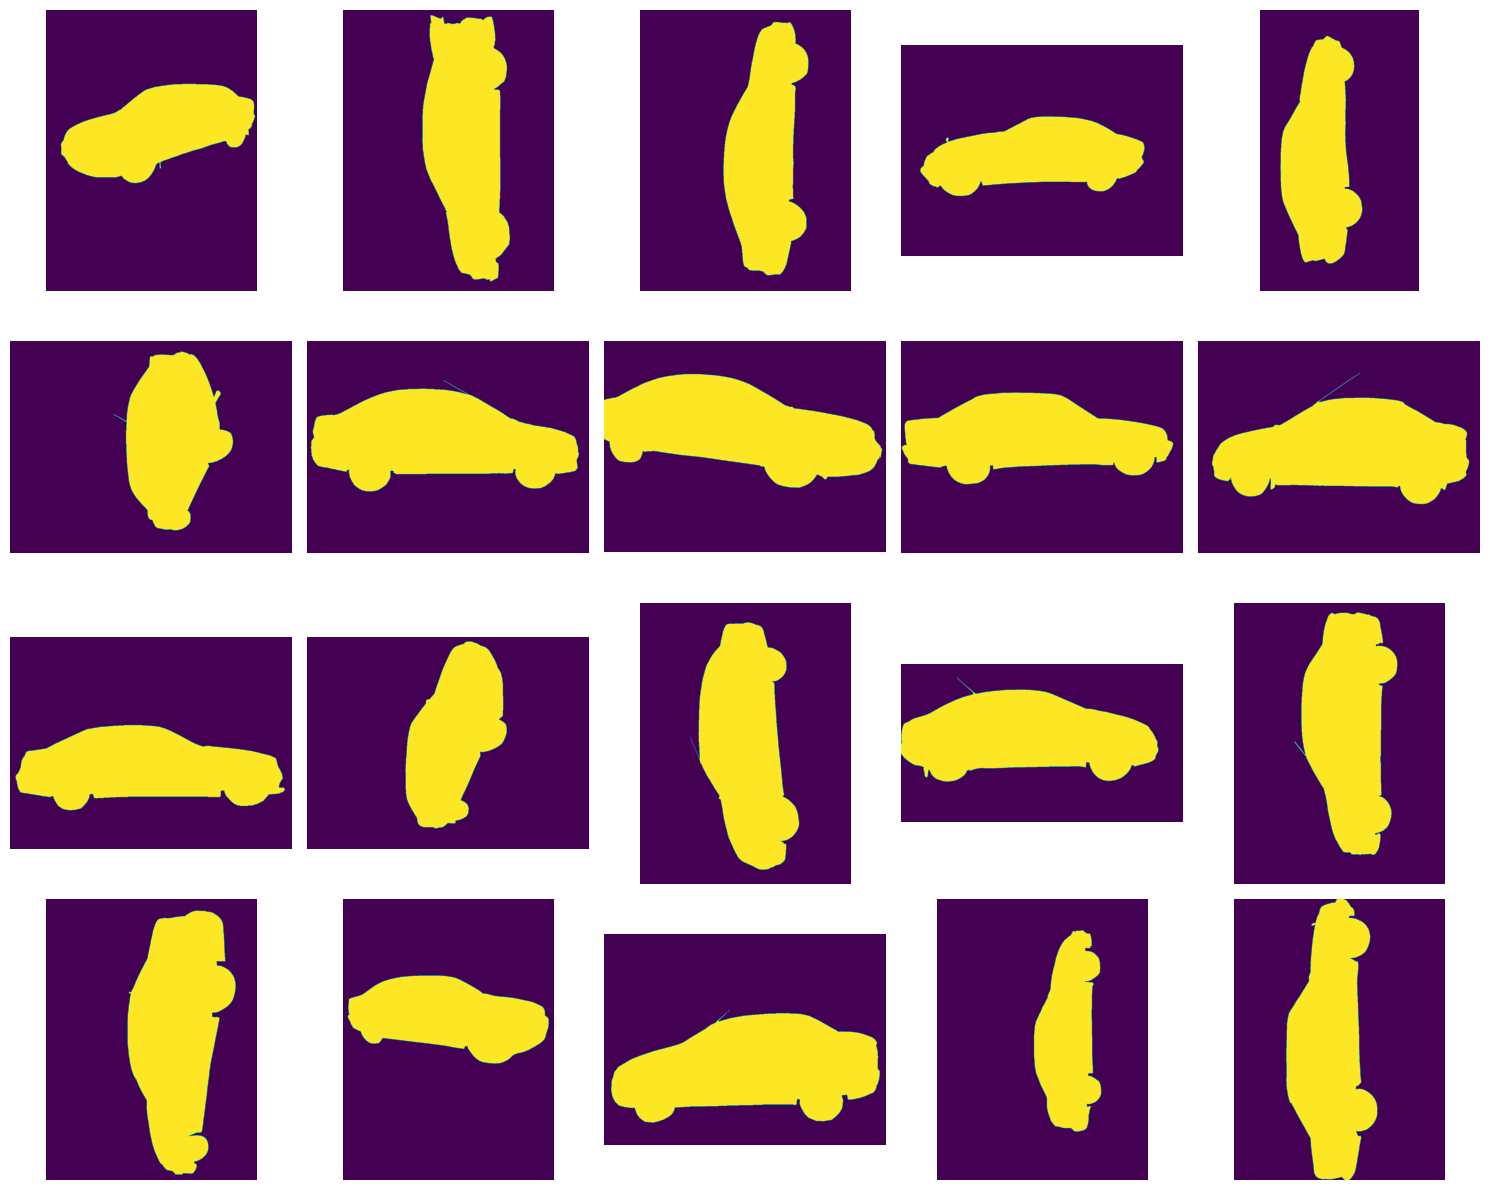

In [ ]:
folder_mask = "/content/Mask" # folder path of masks
masks = [Image.open(os.path.join(folder_mask , f)) for f in os.listdir(folder_mask)] # displaying every mask present in mask folder
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for ax, img in zip(axes.ravel(), masks):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
class CarSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_ext=".jpg", mask_ext=".png", transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ext = image_ext
        self.mask_ext = mask_ext
        self.transform = transform
        self.images = [os.path.splitext(f)[0] for f in os.listdir(image_dir)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name + self.image_ext)
        mask_path = os.path.join(self.mask_dir, img_name + self.mask_ext)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [5]:
# Data Transforms and Splitting the Dataset
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

image_dir = '/content/Image'  # Update with the actual path to your images
mask_dir = '/content/Mask'    # Update with the actual path to your masks

dataset = CarSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
# Split dataset into training and validation sets
train_size = 15
val_size = 5
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [6]:
# Define the U-2-Net Model
from u2net import U2NET  # Assuming model.py contains U2NET class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = U2NET(3, 1)  # 3 input channels (RGB), 1 output channel (mask)
model = model.to(device)

# Define Loss Function and Optimizer
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [7]:
# Define Custom Functions for Dice Score and IoU
def dice_score(preds, targets, smooth=1e-6):
    preds = preds.contiguous()
    targets = targets.contiguous()

    intersection = (preds * targets).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (preds.sum(dim=2).sum(dim=2) + targets.sum(dim=2).sum(dim=2) + smooth)

    return dice.mean().item()

def iou(preds, targets, smooth=1e-6):
    preds = preds.contiguous()
    targets = targets.contiguous()

    intersection = (preds * targets).sum(dim=2).sum(dim=2)
    union = (preds + targets).sum(dim=2).sum(dim=2) - intersection
    iou = (intersection + smooth) / (union + smooth)

    return iou.mean().item()

In [8]:
# Training and Validation Loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # outputs is a tuple, we use the last output for the loss
        loss = criterion(outputs[0], masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    dice = 0
    iou_score = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs[0], masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs[0])
            preds = (preds > 0.5).float()

            dice += dice_score(preds, masks)
            iou_score += iou(preds, masks)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Dice Score: {dice/len(val_loader):.4f}, "
          f"IoU: {iou_score/len(val_loader):.4f} ")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch [1/20], Train Loss: 0.7664, Val Loss: 0.7710, Dice Score: 0.3725, IoU: 0.2320
Epoch [2/20], Train Loss: 0.6671, Val Loss: 0.7140, Dice Score: 0.3725, IoU: 0.2320
Epoch [3/20], Train Loss: 0.6378, Val Loss: 0.7003, Dice Score: 0.3725, IoU: 0.2320
Epoch [4/20], Train Loss: 0.6230, Val Loss: 0.6969, Dice Score: 0.3725, IoU: 0.2320
Epoch [5/20], Train Loss: 0.6162, Val Loss: 0.6955, Dice Score: 0.3725, IoU: 0.2320
Epoch [6/20], Train Loss: 0.6115, Val Loss: 0.6798, Dice Score: 0.3725, IoU: 0.2320
Epoch [7/20], Train Loss: 0.6082, Val Loss: 0.6971, Dice Score: 0.3725, IoU: 0.2320
Epoch [8/20], Train Loss: 0.6082, Val Loss: 0.7005, Dice Score: 0.3725, IoU: 0.2320
Epoch [9/20], Train Loss: 0.6074, Val Loss: 0.6479, Dice Score: 0.3725, IoU: 0.2320
Epoch [10/20], Train Loss: 0.6099, Val Loss: 0.6328, Dice Score: 0.3725, IoU: 0.2320
Epoch [11/20], Train Loss: 0.6059, Val Loss: 0.6656, Dice Score: 0.3725, IoU: 0.2320
Epoch [12/20], Train Loss: 0.6062, Val Loss: 0.6457, Dice Score: 0.3725, I